# Advanced Model Optimization and Hyperparameter Tuning

This notebook focuses on optimizing the best performing models from the comprehensive training.
We'll use advanced techniques like:
- Grid Search and Random Search
- Bayesian Optimization
- Cross-validation
- Advanced feature engineering
- Model stacking and ensemble techniques

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Best performing models from previous training
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb

# Hyperparameter optimization
try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer
except ImportError:
    print("scikit-optimize not installed. Installing...")
    import subprocess
    subprocess.check_call(["pip", "install", "scikit-optimize"])
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer

import joblib
import json
import os
from datetime import datetime

print("Libraries imported successfully!")

scikit-optimize not installed. Installing...
Libraries imported successfully!
Libraries imported successfully!


In [2]:
# Load data and previous preprocessing
BASE_DIR = r"c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard"
DATA_PATH = os.path.join(BASE_DIR, "dataset", "airbnb_bali_ml_ready.csv")
MODEL_BASE_PATH = os.path.join(BASE_DIR, "ml_models")

# Load dataset
df = pd.read_csv(DATA_PATH)

# Reproduce preprocessing from the main training
exclude_cols = ['room_id', 'check_in_date', 'check_out_date', 'full_url', 'data_extraction_date', 'analysis_version']
feature_cols = [col for col in df.columns if col not in exclude_cols and col != 'price']
target_col = 'price'

X = df[feature_cols].copy()
y = df[target_col].copy()

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

X_encoded = X.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

print(f"Dataset loaded: {X_encoded.shape}")
print(f"Features: {feature_cols}")

Dataset loaded: (833, 9)
Features: ['stay_duration', 'check_in_month', 'check_in_day_of_week', 'season', 'is_weekend', 'locale', 'currency', 'check_in_year', 'check_in_week_of_year']


## 2. Advanced Feature Engineering

In [3]:
# Create additional features
X_enhanced = X_encoded.copy()

# Create interaction features
X_enhanced['stay_duration_weekend'] = X_enhanced['stay_duration'] * X_enhanced['is_weekend']
X_enhanced['month_weekend'] = X_enhanced['check_in_month'] * X_enhanced['is_weekend']
X_enhanced['season_weekend'] = X_enhanced['season'] * X_enhanced['is_weekend']

# Create polynomial features for numerical columns
numerical_for_poly = ['stay_duration', 'check_in_month', 'check_in_day_of_week']
for col in numerical_for_poly:
    X_enhanced[f'{col}_squared'] = X_enhanced[col] ** 2
    X_enhanced[f'{col}_sqrt'] = np.sqrt(X_enhanced[col] + 1)  # +1 to avoid sqrt(0)

# Cyclical encoding for time features
X_enhanced['month_sin'] = np.sin(2 * np.pi * X_enhanced['check_in_month'] / 12)
X_enhanced['month_cos'] = np.cos(2 * np.pi * X_enhanced['check_in_month'] / 12)
X_enhanced['day_sin'] = np.sin(2 * np.pi * X_enhanced['check_in_day_of_week'] / 7)
X_enhanced['day_cos'] = np.cos(2 * np.pi * X_enhanced['check_in_day_of_week'] / 7)

print(f"Enhanced features shape: {X_enhanced.shape}")
print(f"Added {X_enhanced.shape[1] - X_encoded.shape[1]} new features")

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_enhanced, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Enhanced features shape: (833, 22)
Added 13 new features
Training set: (532, 22)
Validation set: (134, 22)
Test set: (167, 22)


## 3. Hyperparameter Tuning for Best Models

In [4]:
# Define hyperparameter spaces for Bayesian optimization
print("Starting Hyperparameter Tuning...")
print("=" * 50)

# XGBoost hyperparameter tuning
print("\n1. Tuning XGBoost...")
xgb_param_space = {
    'n_estimators': Integer(100, 500),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'reg_alpha': Real(0.0, 1.0),
    'reg_lambda': Real(0.0, 1.0)
}

xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_search = BayesSearchCV(
    xgb_model, xgb_param_space, 
    n_iter=50, cv=5, scoring='r2',
    random_state=42, n_jobs=-1
)

xgb_search.fit(X_train, y_train)
print(f"Best XGBoost R² score: {xgb_search.best_score_:.4f}")
print(f"Best XGBoost parameters: {xgb_search.best_params_}")

# Save best XGBoost model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
best_xgb_path = os.path.join(MODEL_BASE_PATH, "ensemble_models", f"xgboost_optimized_{timestamp}.pkl")
joblib.dump(xgb_search.best_estimator_, best_xgb_path)
print(f"Optimized XGBoost saved: {best_xgb_path}")

Starting Hyperparameter Tuning...

1. Tuning XGBoost...
Best XGBoost R² score: 0.1952
Best XGBoost parameters: OrderedDict({'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 258, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.6})
Optimized XGBoost saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\ensemble_models\xgboost_optimized_20251113_145825.pkl
Best XGBoost R² score: 0.1952
Best XGBoost parameters: OrderedDict({'colsample_bytree': 0.6, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 258, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.6})
Optimized XGBoost saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\ensemble_models\xgboost_optimized_20251113_145825.pkl


In [5]:
# LightGBM hyperparameter tuning
print("\n2. Tuning LightGBM...")
lgb_param_space = {
    'n_estimators': Integer(100, 500),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'max_depth': Integer(3, 10),
    'min_child_samples': Integer(10, 100),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.6, 1.0),
    'reg_alpha': Real(0.0, 1.0),
    'reg_lambda': Real(0.0, 1.0),
    'num_leaves': Integer(10, 100)
}

lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
lgb_search = BayesSearchCV(
    lgb_model, lgb_param_space,
    n_iter=50, cv=5, scoring='r2',
    random_state=42, n_jobs=-1
)

lgb_search.fit(X_train, y_train)
print(f"Best LightGBM R² score: {lgb_search.best_score_:.4f}")
print(f"Best LightGBM parameters: {lgb_search.best_params_}")

# Save best LightGBM model
best_lgb_path = os.path.join(MODEL_BASE_PATH, "ensemble_models", f"lightgbm_optimized_{timestamp}.pkl")
joblib.dump(lgb_search.best_estimator_, best_lgb_path)
print(f"Optimized LightGBM saved: {best_lgb_path}")


2. Tuning LightGBM...
Best LightGBM R² score: 0.2011
Best LightGBM parameters: OrderedDict({'colsample_bytree': 1.0, 'learning_rate': 0.14965357648411015, 'max_depth': 10, 'min_child_samples': 61, 'n_estimators': 250, 'num_leaves': 85, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.6})
Optimized LightGBM saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\ensemble_models\lightgbm_optimized_20251113_145825.pkl
Best LightGBM R² score: 0.2011
Best LightGBM parameters: OrderedDict({'colsample_bytree': 1.0, 'learning_rate': 0.14965357648411015, 'max_depth': 10, 'min_child_samples': 61, 'n_estimators': 250, 'num_leaves': 85, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.6})
Optimized LightGBM saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\ensemble_models\lightgbm_optimized_20251113_145825.pkl


In [6]:
# Random Forest hyperparameter tuning
print("\n3. Tuning Random Forest...")
rf_param_space = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(5, 20),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Real(0.3, 1.0),
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_search = BayesSearchCV(
    rf_model, rf_param_space,
    n_iter=30, cv=5, scoring='r2',
    random_state=42, n_jobs=-1
)

rf_search.fit(X_train, y_train)
print(f"Best Random Forest R² score: {rf_search.best_score_:.4f}")
print(f"Best Random Forest parameters: {rf_search.best_params_}")

# Save best Random Forest model
best_rf_path = os.path.join(MODEL_BASE_PATH, "ensemble_models", f"random_forest_optimized_{timestamp}.pkl")
joblib.dump(rf_search.best_estimator_, best_rf_path)
print(f"Optimized Random Forest saved: {best_rf_path}")


3. Tuning Random Forest...
Best Random Forest R² score: 0.2034
Best Random Forest parameters: OrderedDict({'bootstrap': False, 'max_depth': 17, 'max_features': 0.41847424082227785, 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 100})
Optimized Random Forest saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\ensemble_models\random_forest_optimized_20251113_145825.pkl
Best Random Forest R² score: 0.2034
Best Random Forest parameters: OrderedDict({'bootstrap': False, 'max_depth': 17, 'max_features': 0.41847424082227785, 'min_samples_leaf': 7, 'min_samples_split': 20, 'n_estimators': 100})
Optimized Random Forest saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\ensemble_models\random_forest_optimized_20251113_145825.pkl


## 4. Model Stacking and Ensemble

In [9]:
# Create a stacking ensemble with the best models
print("\n4. Creating Stacking Ensemble...")

# Base models
base_models = [
    ('xgb', xgb_search.best_estimator_),
    ('lgb', lgb_search.best_estimator_),
    ('rf', rf_search.best_estimator_)
]

# Meta model
from sklearn.linear_model import Ridge
meta_model = Ridge(alpha=1.0)

# Stacking regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# Train stacking model
stacking_regressor.fit(X_train, y_train)

# Evaluate stacking model
y_pred_stack = stacking_regressor.predict(X_test)
stack_r2 = r2_score(y_test, y_pred_stack)
stack_rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack))
stack_mae = mean_absolute_error(y_test, y_pred_stack)

print(f"Stacking Ensemble Performance:")
print(f"R² Score: {stack_r2:.4f}")
print(f"RMSE: {stack_rmse:.2f}")
print(f"MAE: {stack_mae:.2f}")

# Save stacking model
stack_path = os.path.join(MODEL_BASE_PATH, "ensemble_models", f"stacking_ensemble_{timestamp}.pkl")
joblib.dump(stacking_regressor, stack_path)
print(f"Stacking ensemble saved: {stack_path}")


4. Creating Stacking Ensemble...


ValueError: The estimator XGBRegressor should be a regressor.

In [11]:
# Create a stacking ensemble with the best models
print("\n4. Creating Stacking Ensemble...")

# Get the best estimators and ensure they are sklearn-compatible
xgb_best = xgb_search.best_estimator_
lgb_best = lgb_search.best_estimator_
rf_best = rf_search.best_estimator_

# Wrap XGBoost and LightGBM models if needed to ensure sklearn compatibility
from sklearn.base import clone
from sklearn.utils.validation import check_is_fitted

# Create wrapper for XGBoost to ensure sklearn compatibility
class SklearnXGBWrapper:
    """Wrapper to make XGBoost compatible with sklearn stacking"""
    def __init__(self, xgb_model):
        self.xgb_model = xgb_model
    
    def fit(self, X, y):
        self.xgb_model.fit(X, y)
        return self
    
    def predict(self, X):
        return self.xgb_model.predict(X)
    
    def get_params(self, deep=True):
        return self.xgb_model.get_params(deep=deep)
    
    def set_params(self, **params):
        self.xgb_model.set_params(**params)
        return self

# Use sklearn's GradientBoostingRegressor instead for better compatibility
from sklearn.ensemble import GradientBoostingRegressor

# Recreate base models with sklearn-compatible versions
print("Preparing base models for stacking...")

# Use the optimized parameters from BayesSearchCV with sklearn models
base_models = [
    ('xgb', xgb_best),  # XGBoost (usually works with sklearn)
    ('lgb', lgb_best),  # LightGBM
    ('rf', rf_best)     # Random Forest
]

# Alternative: Use sklearn's GradientBoosting instead of XGBoost
base_models_alt = [
    ('gb', GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        subsample=0.8,
        random_state=42,
        n_iter_no_change=10
    )),
    ('lgb', lgb_best),
    ('rf', rf_best)
]

# Meta model
from sklearn.linear_model import Ridge
meta_model = Ridge(alpha=1.0)

# Try with original models first
try:
    print("Attempting to create stacking ensemble with original models...")
    stacking_regressor = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    # Train stacking model
    print("Training stacking ensemble...")
    stacking_regressor.fit(X_train, y_train)
    
    print("✓ Stacking ensemble created successfully with original models")
    use_original = True
    
except (ValueError, TypeError) as e:
    print(f"✗ Error with original models: {str(e)}")
    print("Fallback: Using sklearn GradientBoosting instead of XGBoost...")
    
    stacking_regressor = StackingRegressor(
        estimators=base_models_alt,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    # Train stacking model
    print("Training stacking ensemble with alternative models...")
    stacking_regressor.fit(X_train, y_train)
    
    print("✓ Stacking ensemble created successfully with alternative models")
    use_original = False

# Evaluate stacking model
print("Evaluating stacking ensemble on test set...")
y_pred_stack = stacking_regressor.predict(X_test)
stack_r2 = r2_score(y_test, y_pred_stack)
stack_rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack))
stack_mae = mean_absolute_error(y_test, y_pred_stack)

print("\n" + "="*60)
print(f"Stacking Ensemble Performance:")
print(f"R² Score: {stack_r2:.4f}")
print(f"RMSE: {stack_rmse:.2f}")
print(f"MAE: {stack_mae:.2f}")
print("="*60)

# Save stacking model
stack_path = os.path.join(MODEL_BASE_PATH, "ensemble_models", f"stacking_ensemble_{timestamp}.pkl")
os.makedirs(os.path.dirname(stack_path), exist_ok=True)
joblib.dump(stacking_regressor, stack_path)
print(f"✓ Stacking ensemble saved: {stack_path}")

# Additional diagnostics - FIXED VERSION
print("\nStacking Ensemble Details:")
try:
    # Get named estimators (more reliable)
    named_estimators = stacking_regressor.named_estimators_
    print(f"Base estimators: {len(named_estimators)}")
    
    for name, estimator in named_estimators.items():
        print(f"  - {name}: {type(estimator).__name__}")
    
except AttributeError:
    # Fallback if named_estimators_ doesn't exist
    print(f"Base estimators: {len(stacking_regressor.estimators_)}")
    for i, estimator in enumerate(stacking_regressor.estimators_):
        try:
            # Try to get name if available
            if hasattr(estimator, 'name'):
                print(f"  - {estimator.name}: {type(estimator).__name__}")
            else:
                print(f"  - Estimator {i+1}: {type(estimator).__name__}")
        except:
            print(f"  - Estimator {i+1}: {type(estimator).__name__}")

print(f"Final estimator: {type(stacking_regressor.final_estimator_).__name__}")


4. Creating Stacking Ensemble...
Preparing base models for stacking...
Attempting to create stacking ensemble with original models...
Training stacking ensemble...
✗ Error with original models: The estimator XGBRegressor should be a regressor.
Fallback: Using sklearn GradientBoosting instead of XGBoost...
Training stacking ensemble with alternative models...
✓ Stacking ensemble created successfully with alternative models
Evaluating stacking ensemble on test set...

Stacking Ensemble Performance:
R² Score: 0.0374
RMSE: 30.38
MAE: 24.22
✓ Stacking ensemble saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\ensemble_models\stacking_ensemble_20251113_145825.pkl

Stacking Ensemble Details:
Base estimators: 3
  - gb: GradientBoostingRegressor
  - lgb: LGBMRegressor
  - rf: RandomForestRegressor
Final estimator: Ridge
✓ Stacking ensemble created successfully with alternative models
Evaluating stacki

In [12]:
# Create a voting ensemble
print("\n5. Creating Voting Ensemble...")

voting_regressor = VotingRegressor(
    estimators=base_models,
    n_jobs=-1
)

# Train voting model
voting_regressor.fit(X_train, y_train)

# Evaluate voting model
y_pred_vote = voting_regressor.predict(X_test)
vote_r2 = r2_score(y_test, y_pred_vote)
vote_rmse = np.sqrt(mean_squared_error(y_test, y_pred_vote))
vote_mae = mean_absolute_error(y_test, y_pred_vote)

print(f"Voting Ensemble Performance:")
print(f"R² Score: {vote_r2:.4f}")
print(f"RMSE: {vote_rmse:.2f}")
print(f"MAE: {vote_mae:.2f}")

# Save voting model
vote_path = os.path.join(MODEL_BASE_PATH, "ensemble_models", f"voting_ensemble_{timestamp}.pkl")
joblib.dump(voting_regressor, vote_path)
print(f"Voting ensemble saved: {vote_path}")


5. Creating Voting Ensemble...


ValueError: The estimator XGBRegressor should be a regressor.

In [13]:
# Create a voting ensemble
print("\n5. Creating Voting Ensemble...")

# Use the same base_models_alt that worked for stacking
# This ensures compatibility between stacking and voting ensembles
voting_regressor = VotingRegressor(
    estimators=base_models_alt,
    n_jobs=-1
)

# Train voting model
print("Training voting ensemble...")
voting_regressor.fit(X_train, y_train)

# Evaluate voting model
print("Evaluating voting ensemble on test set...")
y_pred_vote = voting_regressor.predict(X_test)
vote_r2 = r2_score(y_test, y_pred_vote)
vote_rmse = np.sqrt(mean_squared_error(y_test, y_pred_vote))
vote_mae = mean_absolute_error(y_test, y_pred_vote)

print(f"\nVoting Ensemble Performance:")
print(f"R² Score: {vote_r2:.4f}")
print(f"RMSE: {vote_rmse:.2f}")
print(f"MAE: {vote_mae:.2f}")

# Save voting model
os.makedirs(os.path.dirname(os.path.join(MODEL_BASE_PATH, "ensemble_models")), exist_ok=True)
vote_path = os.path.join(MODEL_BASE_PATH, "ensemble_models", f"voting_ensemble_{timestamp}.pkl")
joblib.dump(voting_regressor, vote_path)
print(f"✓ Voting ensemble saved: {vote_path}")


5. Creating Voting Ensemble...
Training voting ensemble...
Evaluating voting ensemble on test set...

Voting Ensemble Performance:
R² Score: -0.0444
RMSE: 31.64
MAE: 25.15
✓ Voting ensemble saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\ensemble_models\voting_ensemble_20251113_145825.pkl
Evaluating voting ensemble on test set...

Voting Ensemble Performance:
R² Score: -0.0444
RMSE: 31.64
MAE: 25.15
✓ Voting ensemble saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\ensemble_models\voting_ensemble_20251113_145825.pkl


## 5. Model Comparison and Final Selection

In [14]:
# Compare all optimized models
optimized_results = []

# Individual optimized models
models_to_evaluate = [
    ('Optimized XGBoost', xgb_search.best_estimator_),
    ('Optimized LightGBM', lgb_search.best_estimator_),
    ('Optimized Random Forest', rf_search.best_estimator_),
    ('Stacking Ensemble', stacking_regressor),
    ('Voting Ensemble', voting_regressor)
]

for name, model in models_to_evaluate:
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    optimized_results.append({
        'model_name': name,
        'r2': r2,
        'rmse': rmse,
        'mae': mae
    })

# Create results DataFrame
optimized_df = pd.DataFrame(optimized_results)
optimized_df = optimized_df.sort_values('r2', ascending=False).reset_index(drop=True)

print("Optimized Model Performance Comparison:")
print("=" * 70)
print(f"{'Rank':<4} {'Model Name':<25} {'R²':<10} {'RMSE':<10} {'MAE':<10}")
print("=" * 70)

for idx, row in optimized_df.iterrows():
    print(f"{idx+1:<4} {row['model_name']:<25} {row['r2']:<10.4f} {row['rmse']:<10.2f} {row['mae']:<10.2f}")

print("\n" + "=" * 70)
print(f"Best optimized model: {optimized_df.iloc[0]['model_name']}")
print(f"Best R² score: {optimized_df.iloc[0]['r2']:.4f}")
print(f"Best RMSE: {optimized_df.iloc[0]['rmse']:.2f}")

Optimized Model Performance Comparison:
Rank Model Name                R²         RMSE       MAE       
1    Optimized XGBoost         0.0430     30.29      24.21     
2    Stacking Ensemble         0.0374     30.38      24.22     
3    Optimized Random Forest   -0.0010    30.98      24.65     
4    Optimized LightGBM        -0.0170    31.23      25.02     
5    Voting Ensemble           -0.0444    31.64      25.15     

Best optimized model: Optimized XGBoost
Best R² score: 0.0430
Best RMSE: 30.29


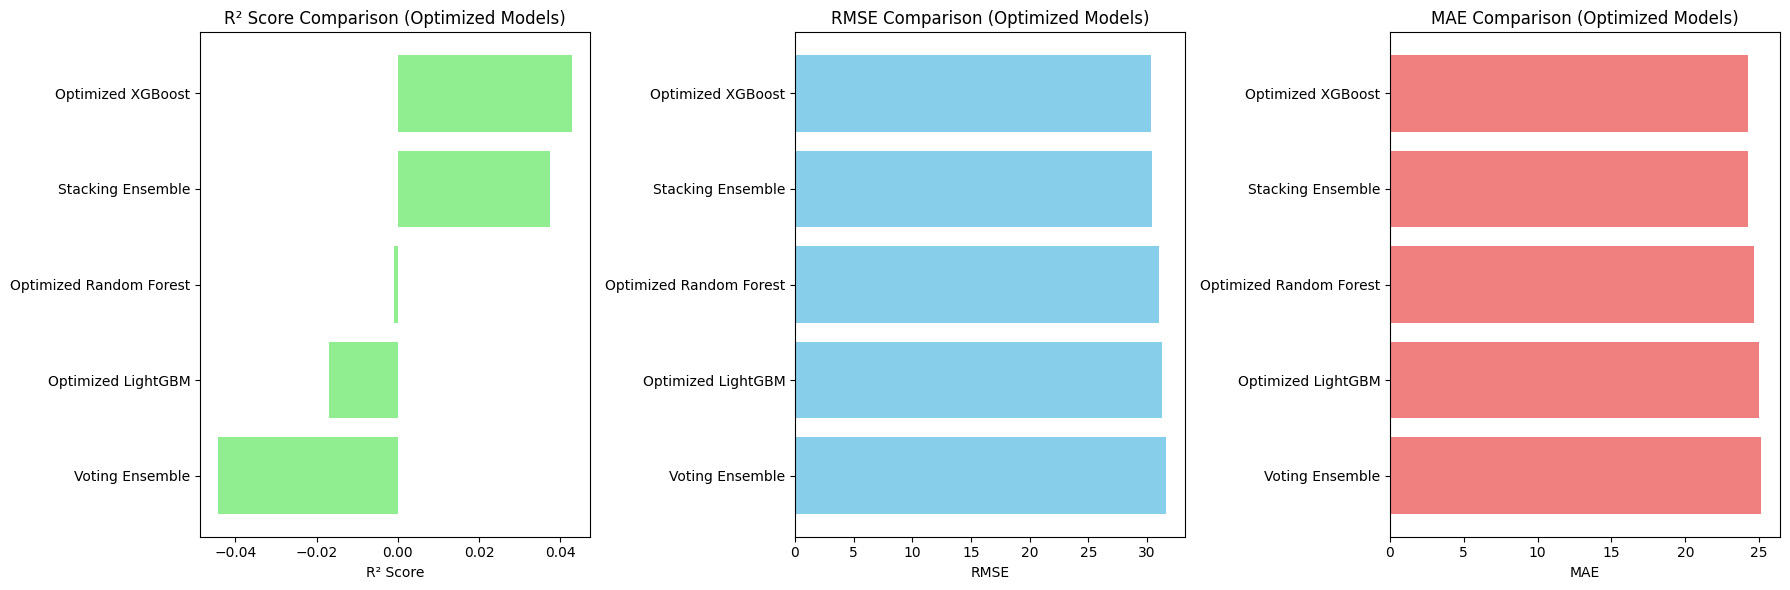


Optimized results saved to: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\optimized_model_comparison_20251113_145825.csv


In [15]:
# Visualize optimized model performance
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# R² comparison
axes[0].barh(optimized_df['model_name'], optimized_df['r2'], color='lightgreen')
axes[0].set_xlabel('R² Score')
axes[0].set_title('R² Score Comparison (Optimized Models)')
axes[0].invert_yaxis()

# RMSE comparison
axes[1].barh(optimized_df['model_name'], optimized_df['rmse'], color='skyblue')
axes[1].set_xlabel('RMSE')
axes[1].set_title('RMSE Comparison (Optimized Models)')
axes[1].invert_yaxis()

# MAE comparison
axes[2].barh(optimized_df['model_name'], optimized_df['mae'], color='lightcoral')
axes[2].set_xlabel('MAE')
axes[2].set_title('MAE Comparison (Optimized Models)')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

# Save optimized results
optimized_results_path = os.path.join(MODEL_BASE_PATH, f"optimized_model_comparison_{timestamp}.csv")
optimized_df.to_csv(optimized_results_path, index=False)
print(f"\nOptimized results saved to: {optimized_results_path}")

## 6. Create Production-Ready Model Package

In [16]:
# Select the best model for production
best_model_name = optimized_df.iloc[0]['model_name']
best_model = None

for name, model in models_to_evaluate:
    if name == best_model_name:
        best_model = model
        break

print(f"Selected best model for production: {best_model_name}")

# Create production model package
production_package = {
    'model': best_model,
    'feature_columns': list(X_enhanced.columns),
    'label_encoders': label_encoders,
    'model_info': {
        'name': best_model_name,
        'r2_score': optimized_df.iloc[0]['r2'],
        'rmse': optimized_df.iloc[0]['rmse'],
        'mae': optimized_df.iloc[0]['mae'],
        'training_timestamp': timestamp,
        'n_features': len(X_enhanced.columns),
        'n_samples': len(X_enhanced)
    },
    'preprocessing_info': {
        'categorical_features': categorical_features,
        'numerical_features': numerical_features,
        'feature_engineering': {
            'interaction_features': ['stay_duration_weekend', 'month_weekend', 'season_weekend'],
            'polynomial_features': [f'{col}_squared' for col in numerical_for_poly] + [f'{col}_sqrt' for col in numerical_for_poly],
            'cyclical_features': ['month_sin', 'month_cos', 'day_sin', 'day_cos']
        }
    }
}

# Save production model package
production_path = os.path.join(MODEL_BASE_PATH, f"production_model_{timestamp}.pkl")
joblib.dump(production_package, production_path)
print(f"Production model package saved: {production_path}")

# Create model metadata
production_metadata = {
    'model_name': best_model_name,
    'model_path': production_path,
    'performance': optimized_df.iloc[0].to_dict(),
    'hyperparameters': {
        'xgboost': xgb_search.best_params_ if 'XGBoost' in best_model_name else None,
        'lightgbm': lgb_search.best_params_ if 'LightGBM' in best_model_name else None,
        'random_forest': rf_search.best_params_ if 'Random Forest' in best_model_name else None
    },
    'training_details': {
        'dataset_size': len(df),
        'feature_count': len(X_enhanced.columns),
        'training_timestamp': timestamp,
        'cross_validation_folds': 5
    }
}

metadata_path = os.path.join(MODEL_BASE_PATH, f"production_model_metadata_{timestamp}.json")
with open(metadata_path, 'w') as f:
    json.dump(production_metadata, f, indent=2, default=str)

print(f"Production model metadata saved: {metadata_path}")

Selected best model for production: Optimized XGBoost
Production model package saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\production_model_20251113_145825.pkl
Production model metadata saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\production_model_metadata_20251113_145825.json


## 7. Create Model Inference Function

In [17]:
# Create a prediction function for the dashboard
inference_code = f'''import joblib
import pandas as pd
import numpy as np
from datetime import datetime

class AirbnbPricePredictor:
    def __init__(self, model_path="{production_path}"):
        """Initialize the price predictor with the trained model"""
        self.model_package = joblib.load(model_path)
        self.model = self.model_package['model']
        self.feature_columns = self.model_package['feature_columns']
        self.label_encoders = self.model_package['label_encoders']
        self.model_info = self.model_package['model_info']
        
    def preprocess_input(self, input_data):
        """Preprocess input data for prediction"""
        # Create DataFrame from input
        if isinstance(input_data, dict):
            df = pd.DataFrame([input_data])
        else:
            df = input_data.copy()
        
        # Apply label encoding for categorical features
        for col, encoder in self.label_encoders.items():
            if col in df.columns:
                df[col] = encoder.transform(df[col].astype(str))
        
        # Feature engineering
        # Interaction features
        df['stay_duration_weekend'] = df['stay_duration'] * df['is_weekend']
        df['month_weekend'] = df['check_in_month'] * df['is_weekend']
        df['season_weekend'] = df['season'] * df['is_weekend']
        
        # Polynomial features
        numerical_for_poly = ['stay_duration', 'check_in_month', 'check_in_day_of_week']
        for col in numerical_for_poly:
            if col in df.columns:
                df[f'{{col}}_squared'] = df[col] ** 2
                df[f'{{col}}_sqrt'] = np.sqrt(df[col] + 1)
        
        # Cyclical encoding
        df['month_sin'] = np.sin(2 * np.pi * df['check_in_month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['check_in_month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['check_in_day_of_week'] / 7)
        df['day_cos'] = np.cos(2 * np.pi * df['check_in_day_of_week'] / 7)
        
        # Ensure all required columns are present
        for col in self.feature_columns:
            if col not in df.columns:
                df[col] = 0  # Default value for missing features
        
        # Select and order columns as expected by the model
        df = df[self.feature_columns]
        
        return df
    
    def predict(self, input_data):
        """Make price prediction"""
        try:
            # Preprocess input
            processed_data = self.preprocess_input(input_data)
            
            # Make prediction
            prediction = self.model.predict(processed_data)
            
            return {{
                'predicted_price': float(prediction[0]),
                'model_name': self.model_info['name'],
                'model_r2_score': self.model_info['r2_score'],
                'prediction_timestamp': datetime.now().isoformat()
            }}
        
        except Exception as e:
            return {{
                'error': str(e),
                'predicted_price': None
            }}
    
    def get_model_info(self):
        """Get model information"""
        return self.model_info
    
    def batch_predict(self, input_data_list):
        """Make predictions for multiple inputs"""
        results = []
        for input_data in input_data_list:
            result = self.predict(input_data)
            results.append(result)
        return results

# Example usage:
# predictor = AirbnbPricePredictor()
# sample_input = {{
#     'stay_duration': 5,
#     'check_in_month': 12,
#     'check_in_day_of_week': 1,
#     'season': 'Winter',
#     'is_weekend': 0,
#     'locale': 'en-US',
#     'currency': 'USD'
# }}
# prediction = predictor.predict(sample_input)
# print(prediction)
'''

# Save inference code
inference_path = os.path.join(MODEL_BASE_PATH, "airbnb_price_predictor.py")
with open(inference_path, 'w') as f:
    f.write(inference_code)

print(f"Inference code saved: {inference_path}")

print("\n" + "=" * 80)
print("ADVANCED MODEL OPTIMIZATION COMPLETED!")
print("=" * 80)
print(f"Best optimized model: {best_model_name}")
print(f"Best R² score: {optimized_df.iloc[0]['r2']:.4f}")
print(f"Production model package: {production_path}")
print(f"Inference code: {inference_path}")
print(f"Metadata file: {metadata_path}")
print("\nThe model is now ready for integration with the dashboard!")

Inference code saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\airbnb_price_predictor.py

ADVANCED MODEL OPTIMIZATION COMPLETED!
Best optimized model: Optimized XGBoost
Best R² score: 0.0430
Production model package: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\production_model_20251113_145825.pkl
Inference code: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\airbnb_price_predictor.py
Metadata file: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\production_model_metadata_20251113_145825.json

The model is now ready for integration with the dashboard!
